In [1]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchinfo import summary

In [2]:
# CUDA?
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("CUDA Available?", use_cuda)

CUDA Available? True


In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
DATAPATH:str = os.path.join(os.environ["HOME"],"Documents","Data")

In [5]:
# Dataset
train_data = datasets.MNIST(root = DATAPATH, train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST(root = DATAPATH, train=False, download=False, transform=test_transforms)

In [6]:
#DataLoader
batch_size = 128
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [7]:
len(train_loader), len(test_loader),  len(train_data), len(test_data)

(469, 79, 60000, 10000)

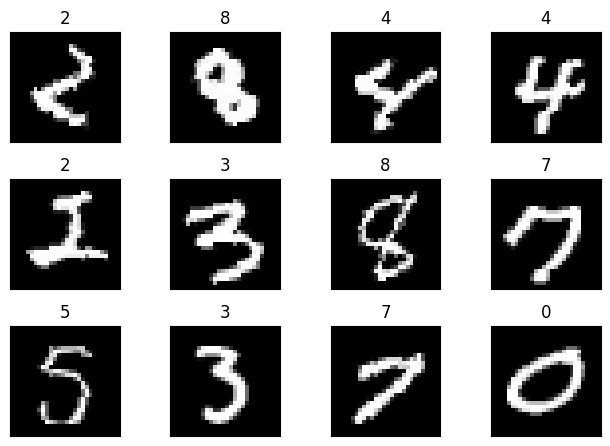

In [8]:
#Be Doctor
import matplotlib.pyplot as plt
batch_data, batch_label = next(iter(train_loader)) 
fig = plt.figure()
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])
plt.show()

In [9]:
#TODO: Our CNN Model
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))                  # 28>26    | 1>3     | 1>1 
        x = F.relu(F.max_pool2d(self.conv2(x),2))  # 26>24>12 | 3>5>6   | 1>1>2
        x = F.relu(self.conv3(x))                  # 12>10    | 6>10    | 2>2
        x = F.relu(F.max_pool2d(self.conv4(x),2))  # 10>8>4   | 10>14>16| 2>2>4
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = model = Net().to(device)

RF of the nn = 16

In [10]:
#TODO: Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [12]:
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [13]:
#Loss Function
criterion = F.cross_entropy

In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Epoch 1


Train: Loss=0.0811 Batch_id=468 Accuracy=83.86: 100%|██████████| 469/469 [00:05<00:00, 89.72it/s]


Test set: Average loss: 0.0977, Accuracy: 58192/60000 (96.99%)

Epoch 2


Train: Loss=0.0627 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:04<00:00, 96.77it/s] 


Test set: Average loss: 0.0645, Accuracy: 58804/60000 (98.01%)

Epoch 3


Train: Loss=0.0733 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:04<00:00, 95.42it/s]


Test set: Average loss: 0.0498, Accuracy: 59060/60000 (98.43%)

Epoch 4


Train: Loss=0.0578 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:05<00:00, 93.64it/s]


Test set: Average loss: 0.0425, Accuracy: 59221/60000 (98.70%)

Epoch 5


Train: Loss=0.0366 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:05<00:00, 91.56it/s]


Test set: Average loss: 0.0365, Accuracy: 59308/60000 (98.85%)

Epoch 6


Train: Loss=0.0048 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:05<00:00, 91.62it/s]


Test set: Average loss: 0.0414, Accuracy: 59201/60000 (98.67%)

Epoch 7


Train: Loss=0.0132 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:05<00:00, 90.18it/s]


Test set: Average loss: 0.0340, Accuracy: 59317/60000 (98.86%)

Epoch 8


Train: Loss=0.0225 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:05<00:00, 89.97it/s]


Test set: Average loss: 0.0304, Accuracy: 59430/60000 (99.05%)

Epoch 9


Train: Loss=0.0588 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:05<00:00, 89.29it/s]


Test set: Average loss: 0.0276, Accuracy: 59508/60000 (99.18%)

Epoch 10


Train: Loss=0.0271 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:05<00:00, 85.61it/s]


Test set: Average loss: 0.0225, Accuracy: 59551/60000 (99.25%)



Text(0.5, 1.0, 'Test Accuracy')

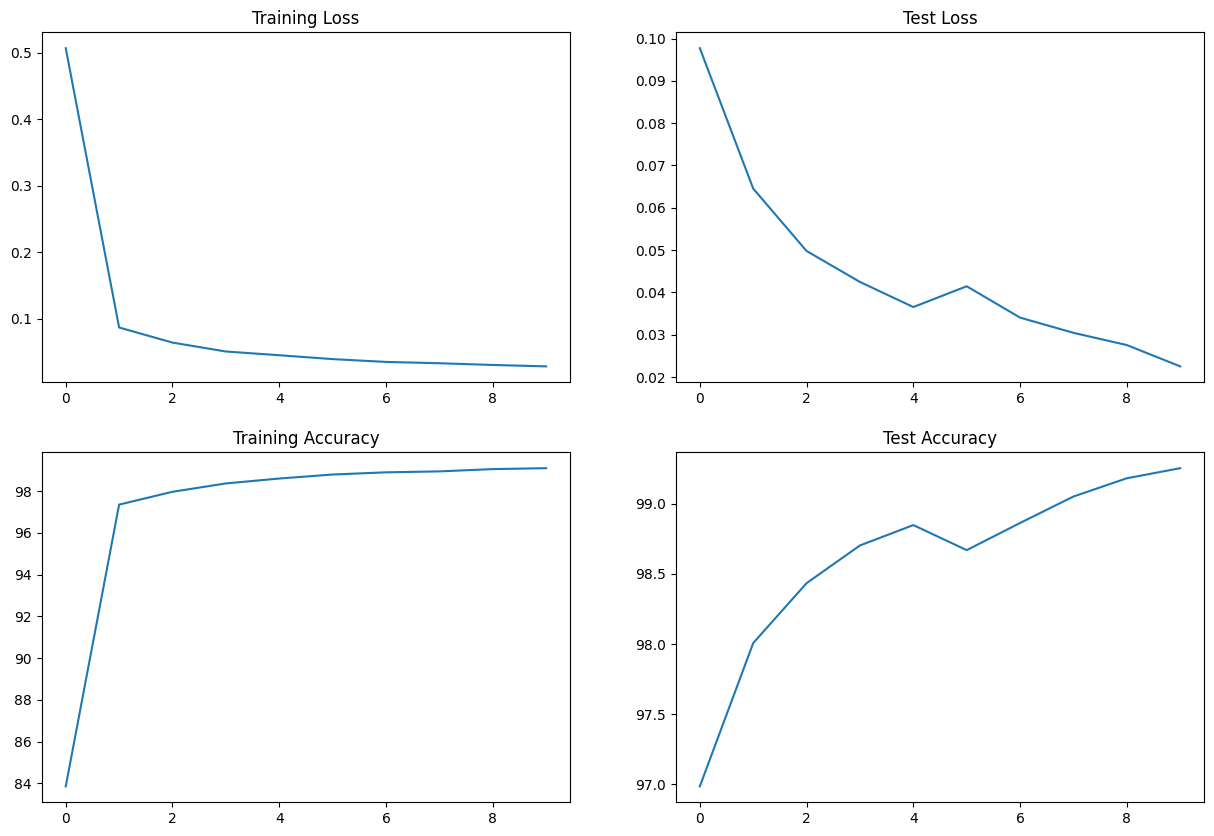

In [15]:
num_epochs = 10

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [32, 26, 26]              320
├─Conv2d: 1-2                            [64, 24, 24]              18,496
├─Conv2d: 1-3                            [128, 10, 10]             73,856
├─Conv2d: 1-4                            [256, 8, 8]               295,168
├─Linear: 1-5                            [1, 50]                   204,850
├─Linear: 1-6                            [1, 10]                   510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 727.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.70
Params size (MB): 2.37
Estimated Total Size (MB): 3.08